In [521]:
#from data_generator import dgen, pack_by_value, downscale_nsave, Camera_source, data_generator, dir_source, resize_tuple
from sources.Camera import thr_camera
#from fit_pca import plot_images_table, get_pca_sk_transformer

import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

import os, time, shutil

from IPython import display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
try:
    cam.release()
except:pass
cam = cv2.VideoCapture(0)

cam.isOpened()

True

## Just view the camera

In [3]:
gen, p = thr_camera(cam, q_size=0)
im_prev = np.zeros((10,10))
for im in gen:
    if im is not None:
        im_prev = im
        continue
    else:
        time.sleep(.4)
        display.clear_output()
        plt.imshow(im_prev)
        plt.show()
    

KeyboardInterrupt: 

In [4]:
# an optional path of where to save data
from webvis import Vis
vis = Vis(ws_port=7700, vis_port=81)

No module named 'seaborn'
No module named 'bokeh'
path /root/danlkv/pywebviz/python/webvis/__init__.py
Starting ws server at localhost:7700
Starting http at 81
Client requested path /
Client requested path /index.bundle.js


127.0.0.1 - - [16/Jul/2019 17:52:13] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [16/Jul/2019 17:52:14] "GET /index.bundle.js?935e9b56d68b4c37c3d9 HTTP/1.1" 200 -


WebSocket::	 Connection closed
Client requested path /
Client requested path /index.bundle.js


127.0.0.1 - - [16/Jul/2019 17:52:28] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [16/Jul/2019 17:52:28] "GET /index.bundle.js?935e9b56d68b4c37c3d9 HTTP/1.1" 200 -


Client requested path /favicon.ico


127.0.0.1 - - [16/Jul/2019 17:52:29] "GET /favicon.ico HTTP/1.1" 200 -


In [5]:
vis.vars['test']='hello'

In [6]:
#from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
import server
server.start()


Tue Jul 16 17:53:03 2019 Server Starts - :80


<DummyProcess(Thread-8, started 139813109397248)>

In [7]:
rot_value = [0]
def rot_gen():
    while True:
        yield rot_value[0]

server.bind(rot_value)

In [8]:
from data_generator import resize_gen
import server

def time_gen():
    start = time.time()
    while True:
        yield time.time() - start
        
def dir_saver(gen,path):
    for x,y in gen:
        for i,im,label in zip(range(len(x)),x,y):
            cv2.imwrite(path+str(label)+'_'+str(i)+'.png',im)
        yield x,y
            
def packer(gen,y_gen,delay=0.1,size=12):
    """ appends and yields if got none """
    pack= []
    pack_y = []
    for im in gen:
        if im is not None:
            y = next(y_gen)
            pack.append(im)
            pack_y.append(y)
            continue
        else:
            time.sleep(delay)
            if len(pack)>size:
                yield pack,np.array(pack_y)
                pack=[]
                pack_y=[]
                
def pipeline():
    gen, p = thr_camera(cam)
    res = resize_gen(gen, factor=0.3)
    xy = packer(res, rot_gen())
    xy = dir_saver(xy,path='../data/img/')
    #xy = ((x, np.ones(len(x))*y) for x,y in xy)
    return xy
    

In [9]:
transformer = IncrementalPCA(
    n_components=10,
    batch_size=200
)
#train_gen = pipeline()
def remove_random(arr, count):
    count = min(len(arr),count)
    for i in range(count):
        arr.pop(random.randrange(len(arr)))
    return arr
    
def cached_random_gen(gen, cache_size=1000):
    cache = []
    for x,y in gen:
        if len(cache)>cache_size:
            cache = remove_random(cache, count=len(x))
        for xy in zip(x,y):
            cache.append(xy)
        xs = [x for x,y in cache]
        ys = [y for x,y in cache]
        xs,ys = np.array(xs),np.array(ys)
        yield xs,ys
        
def transformed_gen(gen):
    for im, y in gen:
        vis.vars['img'] = im[0]
        print('len',len(im), 'sh', im[0].shape)
        vec = np.array([i.flatten() for i in im])
        #print(vec.shape)
        transformer.partial_fit(vec)
        x = transformer.transform(vec)
        var = transformer.explained_variance_ratio_
        print(sum(var),var[:5])
        y = y*100
        yield x, y
        
def printer(gen):
    for x,y in gen:
        print('shapes',x.shape,y.shape)
        print('means',np.mean(x), np.mean(y))
        print('stds',np.std(x), np.std(y))
        vis.vars['ys'] = y.tolist()
        vis.vars['sampl'] = x[0].tolist()
        yield x,y
    

In [10]:
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Input, Flatten, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [11]:
#layers
inp_s = 10
first = 10
second = 5
out = 1

In [12]:
inp = Input(shape = [inp_s])
x = BatchNormalization()(inp)
x = Dense(first, activation='relu')(x)
x = Dense(second, activation='relu')(x)
x = Dense(out, activation='relu')(x)
model = Model(inp, x)
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)

model.compile(loss='mse',optimizer=opt)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
def shuffler(gen):
    for x,y in gen:
        a = list(zip(x,y))
        random.shuffle(a)
        x,y = [x for x,y in a], [y for x,y in a] 
        x,y = np.array(x),np.array(y)
        yield x,y

In [14]:
pipe = pipeline()

In [15]:
x,y = next(pipe)
x,y

([array([[[0, 1, 0],
          [0, 1, 0],
          [0, 1, 0],
          ...,
          [0, 1, 0],
          [0, 1, 0],
          [0, 1, 0]],
  
         [[0, 1, 0],
          [0, 1, 0],
          [0, 1, 0],
          ...,
          [0, 1, 0],
          [0, 1, 0],
          [1, 1, 0]],
  
         [[0, 1, 0],
          [0, 1, 0],
          [0, 1, 0],
          ...,
          [0, 1, 0],
          [0, 1, 0],
          [0, 1, 0]],
  
         ...,
  
         [[0, 1, 0],
          [0, 0, 0],
          [0, 1, 0],
          ...,
          [0, 1, 0],
          [0, 1, 0],
          [0, 1, 0]],
  
         [[0, 1, 0],
          [0, 1, 0],
          [0, 1, 0],
          ...,
          [0, 1, 0],
          [0, 1, 0],
          [0, 1, 0]],
  
         [[0, 1, 0],
          [0, 1, 0],
          [0, 1, 0],
          ...,
          [0, 1, 0],
          [0, 1, 0],
          [0, 1, 0]]], dtype=uint8), array([[[0, 1, 0],
          [0, 1, 0],
          [0, 0, 0],
          ...,
          [0, 1, 0],
    

Client requested path /
Client requested path /index.bundle.js


127.0.0.1 - - [16/Jul/2019 17:55:24] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [16/Jul/2019 17:55:25] "GET /index.bundle.js?935e9b56d68b4c37c3d9 HTTP/1.1" 200 -


Client requested path /favicon.ico


127.0.0.1 - - [16/Jul/2019 17:55:25] "GET /favicon.ico HTTP/1.1" 200 -


path /
fail /


93.175.19.48 - - [16/Jul/2019 17:57:44] "GET / HTTP/1.1" 400 -


Client requested path /
Client requested path /index.bundle.js


127.0.0.1 - - [16/Jul/2019 17:57:47] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [16/Jul/2019 17:57:47] "GET /index.bundle.js?935e9b56d68b4c37c3d9 HTTP/1.1" 200 -


In [ ]:
gen = printer(
    shuffler(
cached_random_gen(
transformed_gen(
pipe
) ) )
)
x,y=  next(gen)
print(x.shape)
print(y.shape,y)
server.VAL

In [ ]:
model.fit_generator(
    gen,
    steps_per_epoch=100,
    epochs = 20,
 )
         # validation_data=(X_train[validate], y_train[validate]))

[5.56175324e+08 6.67193699e+06 1.43841612e+06 3.53453461e+04
 4.05002301e-02]


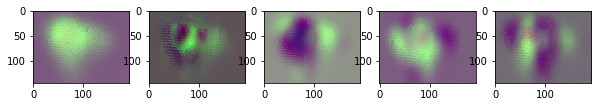

path /0.004772709702357944


10.55.126.145 - - [30/May/2019 23:13:37] "GET /0.004772709702357944 HTTP/1.1" 200 -


path /0.004834557402396598


10.55.126.145 - - [30/May/2019 23:13:40] "GET /0.004834557402396598 HTTP/1.1" 200 -


In [85]:
cmp = transformer.components_

cnt = 5
f, axs = plt.subplots(1,cnt, figsize=(10,15))
v0 = transformer.mean_
a = v0.reshape(144,192,3)
axs[0].imshow(a.astype(np.int))
for i, ax in enumerate(axs[1:]):
    v = cmp[i-1]
    a = v.reshape(144,192,3)
    a -= np.min(a)
    a *= 255/np.max(a)

    ax.imshow(a.astype(np.int))
print(transformer.explained_variance_ratio_[:5])

In [86]:
test_gen = printer(
cached_random_gen(
transformed_gen(
pipe
) ) )

#predictor = model.predict_generator(pca_ed)
for x,y in test_gen:
    x = np.array(x)/256
    pred = model.predict(x)
    vis.vars['pred'] = [
        pred.tolist(),y.tolist()
    ]
    print(pred)
    print(y)


len 15 sh (144, 192, 3)
8.859973367889242e+17 [8.84627699e+17 1.29609289e+15 7.35444394e+13 9.87839569e+04
 3.27598983e+04]
shapes (15, 10) (15,)
means -507.9245973654346 0.4834557402396599
stds 2662.895632232136 5.551115123125783e-17
[[0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]]
[0.48345574 0.48345574 0.48345574 0.48345574 0.48345574 0.48345574
 0.48345574 0.48345574 0.48345574 0.48345574 0.48345574 0.48345574
 0.48345574 0.48345574 0.48345574]
path /0.004896405102435253


10.55.126.145 - - [30/May/2019 23:13:43] "GET /0.004896405102435253 HTTP/1.1" 200 -


len 14 sh (144, 192, 3)
8.80825180102602e+17 [8.79463538e+17 1.28852673e+15 7.31151115e+13 9.82072892e+04
 3.25686570e+04]
shapes (29, 10) (29,)
means -430.4416670121721 0.485161883689002
stds 2738.66295035034 0.002764268322368489
[[0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]]
[0.48345574 0.48345574 0.48345574 0.48345574 0.48345574 0.48345574
 0.48345574 0.48345574 0.48345574 0.48345574 0.48345574 0.48345574
 0.48345574 0.48345574 0.48345574 0.48964051 0.48345574 0.48964051
 0.48964051 0.48964051 0.48964051 0.48345574 0.48345574 0.48964051
 0.48345574 0.48964051 0.48345574 0.48964051 0.48345574]
len 14 sh (144, 192, 3)
8.757440768916342e+17 [8.74390290e+17 1.28

10.55.126.145 - - [30/May/2019 23:13:46] "GET /0.004958252802473908 HTTP/1.1" 200 -


len 14 sh (144, 192, 3)
8.707374774210314e+17 [8.69391430e+17 1.27376980e+15 7.22777563e+13 9.70825644e+04
 3.21956627e+04]
shapes (57, 10) (57,)
means -366.3176254719559 0.48866396761133607
stds 2774.5383546057506 0.004603466115592024
[[0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]]
[0.48345574 0.48345574

10.55.126.145 - - [30/May/2019 23:13:49] "GET /0.005020100502512563 HTTP/1.1" 200 -


len 14 sh (144, 192, 3)
8.612929366286476e+17 [8.59961489e+17 1.25995373e+15 7.14937885e+13 9.60295488e+04
 3.18464494e+04]
shapes (84, 10) (84,)
means -335.8141612907943 0.4919966131021408
stds 2784.1459557801873 0.00639506713070362
[[0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]

10.55.126.145 - - [30/May/2019 23:13:53] "GET /0.005081948202551218 HTTP/1.1" 200 -


path /0.005081948202551218
8.56870974049278e+17 [8.55546362e+17 1.25348501e+15 7.11267323e+13 9.55365236e+04
 3.16829467e+04]
shapes (97, 10) (97,)
means -324.88227331035176 0.4933386201427438
stds 2784.854138206956 0.006859517346430598
[[0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.29689

10.55.126.145 - - [30/May/2019 23:13:56] "GET /0.005143795902589873 HTTP/1.1" 200 -


len 13 sh (144, 192, 3)
8.437154776115419e+17 [8.42411203e+17 1.23424032e+15 7.00347272e+13 9.40697563e+04
 3.11965202e+04]
shapes (137, 10) (137,)
means -293.1278708654526 0.498263072803659
stds 2781.819549680614 0.009724800390597357
[[0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905

10.55.126.145 - - [30/May/2019 23:13:59] "GET /0.005205643602628527 HTTP/1.1" 200 -


len 13 sh (144, 192, 3)
8.351507871091725e+17 [8.33859752e+17 1.22171135e+15 6.93237935e+13 9.31148392e+04
 3.08798395e+04]
shapes (164, 10) (164,)
means -273.75212792991323 0.5014066580557572
stds 2778.6392729967242 0.011433147702948811
[[0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968

10.55.126.145 - - [30/May/2019 23:14:02] "GET /0.005267491302667182 HTTP/1.1" 200 -


len 13 sh (144, 192, 3)
8.266677482901129e+17 [8.25389827e+17 1.20930182e+15 6.86196375e+13 9.21690258e+04
 3.05661779e+04]
shapes (191, 10) (191,)
means -260.08161058948434 0.5045357678444579
stds 2778.517787507603 0.013155294726224932
[[0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.29689

10.55.126.145 - - [30/May/2019 23:14:05] "GET /0.005329339002705837 HTTP/1.1" 200 -


len 14 sh (144, 192, 3)
8.184798171033036e+17 [8.17214553e+17 1.19732400e+15 6.79399777e+13 9.12561154e+04
 3.02634279e+04]
shapes (218, 10) (218,)
means -247.02017856428202 0.5076841511722338
stds 2776.042545086378 0.014930865863725835
[[0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.29689

10.55.126.145 - - [30/May/2019 23:14:08] "GET /0.005391186702744492 HTTP/1.1" 200 -


len 13 sh (144, 192, 3)
8.10538192011578e+17 [8.09285205e+17 1.18570649e+15 6.72807631e+13 9.03706667e+04
 2.99697851e+04]
shapes (245, 10) (245,)
means -237.26381230785634 0.5107192161750668
stds 2772.4311101058997 0.016544521863552715
[[0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.29689

10.55.126.145 - - [30/May/2019 23:14:11] "GET /0.005453034402783147 HTTP/1.1" 200 -


len 13 sh (144, 192, 3)
8.031129779368486e+17 [8.01871469e+17 1.17484441e+15 6.66644145e+13 8.95427952e+04
 2.96952367e+04]
shapes (271, 10) (271,)
means -228.42015677917735 0.5137405734320197
stds 2768.3335220616677 0.018286527670770932
[[0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968

path /0.005514882102821802
len 15 sh (144, 192, 3)


10.55.126.145 - - [30/May/2019 23:14:14] "GET /0.005514882102821802 HTTP/1.1" 200 -


7.953969205771276e+17 [7.94167340e+17 1.16355688e+15 6.60239238e+13 8.86824961e+04
 2.94099343e+04]
shapes (299, 10) (299,)
means -218.65683368930732 0.5167997176518043
stds 2762.650736461557 0.019854050857448215
[[0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.296

10.55.126.145 - - [30/May/2019 23:14:17] "GET /0.005576729802860457 HTTP/1.1" 200 -


len 14 sh (144, 192, 3)
7.878837192263329e+17 [7.86665753e+17 1.15256609e+15 6.54002716e+13 8.78448144e+04
 2.91321325e+04]
shapes (327, 10) (327,)
means -215.23963817004133 0.5199023818220719
stds 2756.7001400241124 0.021536998303588118
[[0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968

10.55.126.145 - - [30/May/2019 23:14:20] "GET /0.005638577502899111 HTTP/1.1" 200 -


len 14 sh (144, 192, 3)
7.803895845690378e+17 [7.79183203e+17 1.14160320e+15 6.47782021e+13 8.70092585e+04
 2.88550357e+04]
shapes (356, 10) (356,)
means -212.9511471534418 0.523222421528559
stds 2749.446392045593 0.02347606215503228
[[0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]

len 13 sh (144, 192, 3)
path /0.005700425202937766
7.770719502623878e+17 [7.75870697e+17 1.13674995e+15 6.45028135e+13 8.66393601e+04
 2.87323656e+04]
shapes (369, 10) (369,)
means -215.3653957943738 0.5246540184767908
stds 2746.3160562919225 0.024245269472662454
[[0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968

10.55.126.145 - - [30/May/2019 23:14:23] "GET /0.005700425202937766 HTTP/1.1" 200 -


len 13 sh (144, 192, 3)
7.738393610512492e+17 [7.72643105e+17 1.13202112e+15 6.42344843e+13 8.62789437e+04
 2.86128401e+04]
shapes (382, 10) (382,)
means -216.81113939247587 0.5261986533553794
stds 2742.655831934033 0.025210138175047598
[[0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.29689

len 16 sh (144, 192, 3)


10.55.126.145 - - [30/May/2019 23:14:27] "GET /0.005762272902976421 HTTP/1.1" 200 -


path /0.005762272902976421
7.69899582775743e+17 [7.68709418e+17 1.12625776e+15 6.39074530e+13 8.58396795e+04
 2.84671662e+04]
shapes (398, 10) (398,)
means -218.04115517037908 0.5279612208704908
stds 2738.4751600347154 0.026156689517823205
[[0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.2968905]
 [0.29

KeyboardInterrupt: 

path /0.005824120603015076


10.55.126.145 - - [30/May/2019 23:14:30] "GET /0.005824120603015076 HTTP/1.1" 200 -


path /0.005885968303053731


10.55.126.145 - - [30/May/2019 23:14:33] "GET /0.005885968303053731 HTTP/1.1" 200 -


path /0.005947816003092386


10.55.126.145 - - [30/May/2019 23:14:36] "GET /0.005947816003092386 HTTP/1.1" 200 -


path /0.0060096637031310405


10.55.126.145 - - [30/May/2019 23:14:39] "GET /0.0060096637031310405 HTTP/1.1" 200 -


path /0.006071511403169695


10.55.126.145 - - [30/May/2019 23:14:42] "GET /0.006071511403169695 HTTP/1.1" 200 -


path /0.0061333591032083495


10.55.126.145 - - [30/May/2019 23:14:45] "GET /0.0061333591032083495 HTTP/1.1" 200 -


path /0.0061952068032470045


10.55.126.145 - - [30/May/2019 23:14:48] "GET /0.0061952068032470045 HTTP/1.1" 200 -


path /0.006257054503285659


10.55.126.145 - - [30/May/2019 23:14:51] "GET /0.006257054503285659 HTTP/1.1" 200 -


path /0.006318902203324314


10.55.126.145 - - [30/May/2019 23:14:54] "GET /0.006318902203324314 HTTP/1.1" 200 -


path /0.006380749903362969


10.55.126.145 - - [30/May/2019 23:14:57] "GET /0.006380749903362969 HTTP/1.1" 200 -


path /0.006442597603401624


10.55.126.145 - - [30/May/2019 23:15:00] "GET /0.006442597603401624 HTTP/1.1" 200 -


path /0.006504445303440278


10.55.126.145 - - [30/May/2019 23:15:03] "GET /0.006504445303440278 HTTP/1.1" 200 -


In [ ]:
from sklearn.externals import joblib # saving pca
_ = joblib.dump(pca, 'PCA'+str(n_components)+'.save')

In [ ]:
pca = joblib.load('PCA'+str(n_components)+'.save')

In [ ]:
transformed = pca.transform(X)

In [ ]:
transformed = transformed/transformed.max()


In [ ]:
angles = np.array([d[1] for d in data])
angles = angels - angels.min()
angles

In [ ]:
enc = OneHotEncoder()
enc.fit(angles.reshape(len(angles),1))
trAng = enc.transform(angles.reshape(len(angles),1))

In [ ]:
#X = [np.array(d.getdata()).flatten() for d in imgs]
X = np.array(X).reshape(len(X), 204, 256, 3)

import matplotlib.pyplot as plt
plt.imshow((X[0]).astype(np.uint8), interpolation='nearest')

In [ ]:
test = np.cumsum([0, 6, 7, 7, 7, 8, 7, 8, 7, 7, 6, 7, 7, 7])
train = np.delete(range(len(X)), test)

In [ ]:
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Input, Flatten, BatchNormalization
from keras.models import Model

In [ ]:
#layers
first = 20
second = 10
out = 1

In [ ]:
inp = Input(shape = (204, 256, 3))
x = MaxPooling2D((2, 2), padding='same')(inp)
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((20, 20), padding='same')(x)
x = Conv2D(1, (2, 2), activation='relu', padding='same')(x)
#x = MaxPooling2D((10, 10), padding='same')(x)
x = Flatten()(x)
x = Dense(first, activation='relu')(x)
x = Dense(second, activation='relu')(x)
x = Dense(out, activation='relu')(x)
model = Model(inp, x)
model.compile(loss='mae', optimizer='adam')

In [ ]:
model.fit(X[train]/256, angles[train]%10/10, batch_size=4, epochs=300, shuffle=True, validation_data=(X[test]/256, angles[test]%10/10))

In [ ]:
pred = model.predict(X[test]/256)*10

In [ ]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(10, 10))
plot=fig.add_subplot(111)
plot.plot(range(len(pred)), pred[:, 0], 'ro-', ms=1)
plot.plot(range(len(pred)), angles[test]%10, 'bo-', ms=1)

In [ ]:
fig=plt.figure(figsize=(10, 10))
plot=fig.add_subplot(111)
plot.plot(angles[test]%10, pred[:, 0], 'ro', ms=10)

In [ ]:
import os
os.listdir('C:\\Users\\ЛФКИТ-3\\Documents\\quantTechLab\\data\\auto_rotate')

# Classical fitting

In [547]:
from fitting_data import gauss_est
from fitting_data import preprocessing

In [585]:
y = np.genfromtxt("/root/Desktop/quantTechLab/data/auto_rotate/ints1_20.csv", delimiter = ',')
x = np.genfromtxt("/root/Desktop/quantTechLab/data/auto_rotate/phases1_20.csv", delimiter = ',')

In [586]:
Y = y
X = x 



In [583]:
len(Y)

3

In [587]:
X = preprocessing().normalized(X, amplitude = 2 * np.pi)
Y = preprocessing().normalized(Y, amplitude = 1)

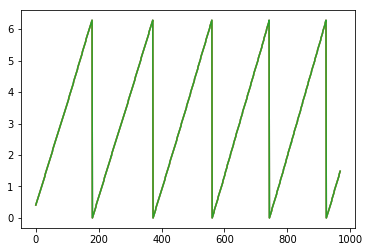

In [588]:
%matplotlib inline
for i in X:
    plt.plot(i)

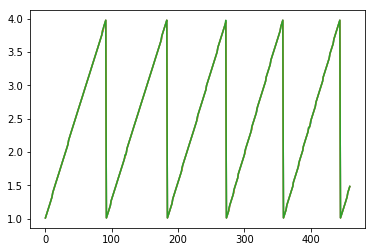

In [589]:
def condition(a):
    return abs(a - 2.5) < 1.5
        
X, Y = preprocessing().valid_data(X, Y, cond = condition)
for i in X:
    plt.plot(i)

In [590]:
est = gauss_est(0.02)

In [591]:
X_train, X_test, Y_train, Y_test = preprocessing().train_test_split(X, Y, test_size = 0.3)

In [592]:
est.fit(X_train, Y_train)

In [593]:
X_predicted, prob_predicted, prob_result = est.predict(Y_test, probability = True) 
X_real = (X_test[0]+X_test[1]+ X_test[2])/3

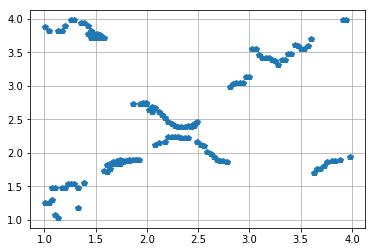

In [598]:

plt.plot(X_real,X_predicted, 'p')
plt.grid()
plt.show()

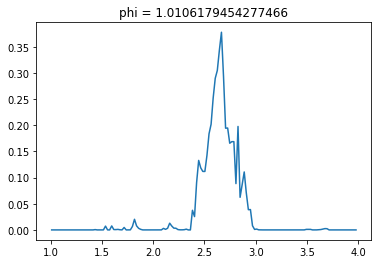

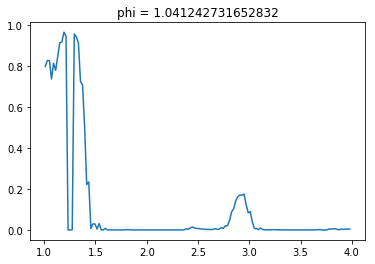

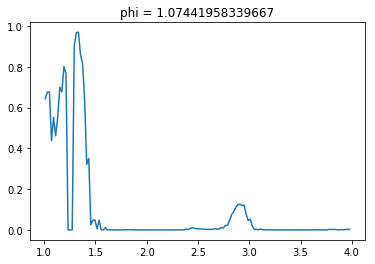

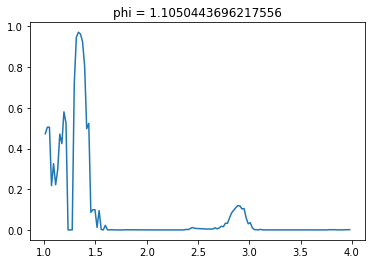

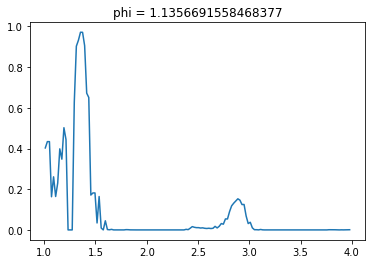

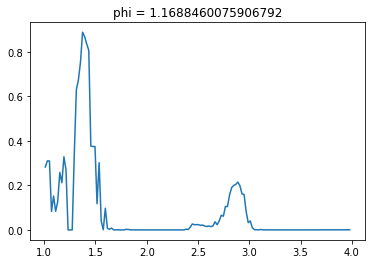

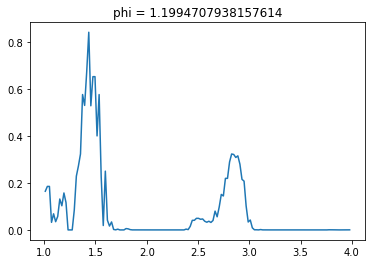

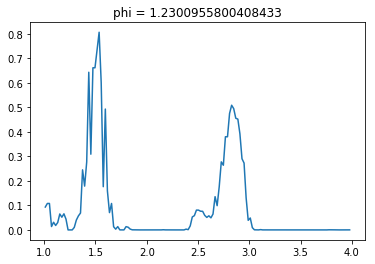

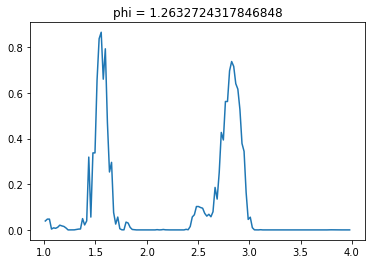

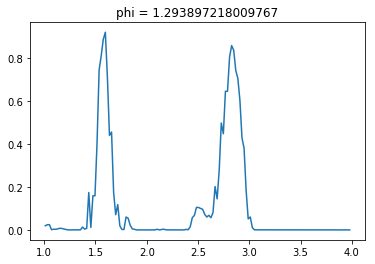

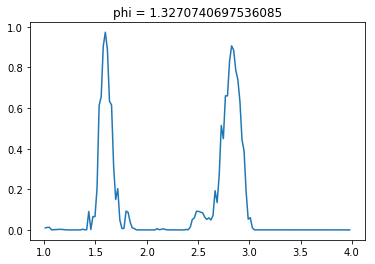

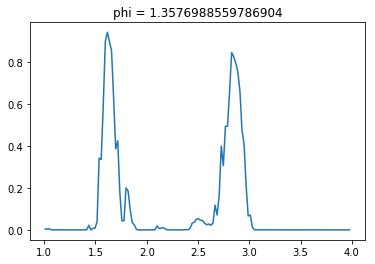

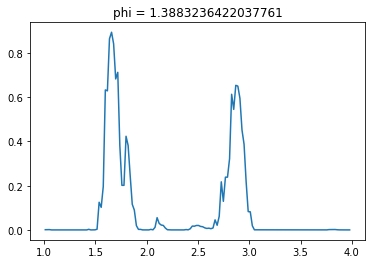

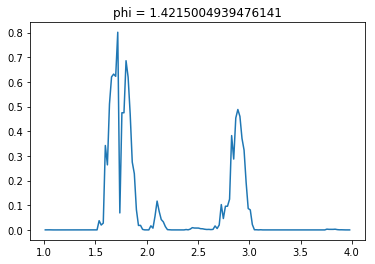

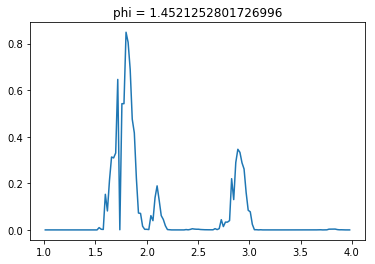

In [518]:
for i in range(0, 15,        plt.plot(est.phis, np.exp(prob_result[i]) )
    plt.title("phi = {}".format(X_real[i]))
    plt.show()

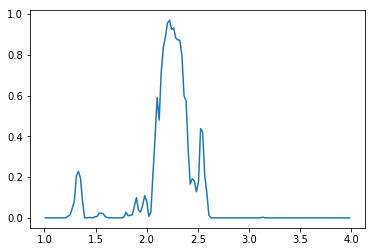

In [154]:
plt.plot(est.phis, np.exp(prob_result[150]) )
plt.show()

In [539]:
np.corrcoef(X_predicted, X_real)

array([[1.        , 0.18200489],
       [0.18200489, 1.        ]])

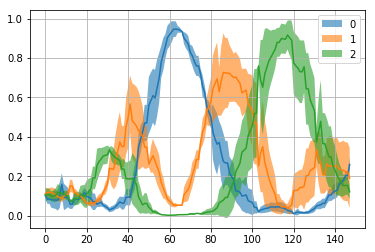

In [595]:
for i in range(3):
    plt.plot(est.mu[i])
    plt.fill_between(range(len(est.mu[0])),est.mu[i]-est.sigma[i],est.mu[i]+est.sigma[i],alpha=0.6, label = i)
    plt.legend()
plt.grid()

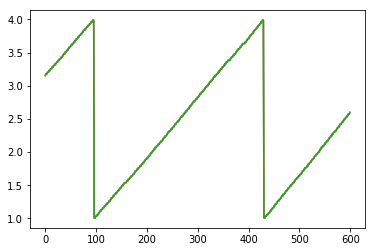

In [373]:
for i in range(3):
    plt.plot(X_train[i])

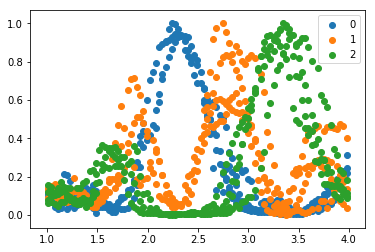

In [596]:
for i in range(3):
    plt.scatter(X_train[i], Y_train[i], label = "{}".format(i))
plt.legend()

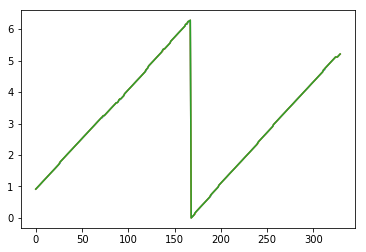

In [507]:
y_test = np.genfromtxt("/root/Desktop/quantTechLab/data/auto_rotate/ints1_test.csv", delimiter = ',')
x_test = np.genfromtxt("/root/Desktop/quantTechLab/data/auto_rotate/phases1_test.csv", delimiter = ',')
Y = y_test
X = x_test
X = preprocessing().normalized(X, amplitude = 2 * np.pi)
Y = preprocessing().normalized(Y, amplitude = 1)
X_test, Y_test = preprocessing().valid_data(X, Y, cond = condition)



for i in X:
    plt.plot(i)
X_predicted, prob_predicted, pr = est.predict(Y_test) 
X_real = (X_test[0]+X_test[1]+X_test[2])/3

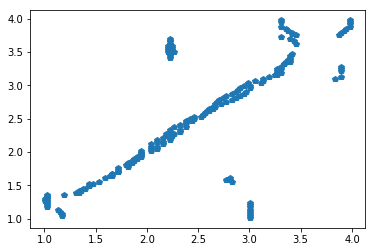

In [508]:
plt.plot(X_predicted, X_real, 'p')

In [509]:
np.corrcoef(X_predicted, X_real)

array([[1.        , 0.73935251],
       [0.73935251, 1.        ]])

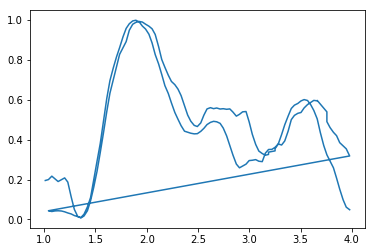

In [510]:
plt.plot(X_test[0], Y_test[0])